# CS471 Term Project

## Introduction
In the lecture, we learned node features of GNNs tend to become more similar with the increase of the network depth. This is known as the **over-smoothing** problem. Intuituvely, as the depth of network grows, the range over which nodes exchange information widens. As learning processes, local information get diluted, and the importance of global information increases, leading to the similarity of feature vectors for much more nodes. This naturally triggers a question: "How can we determine the depth of network to avoid the over-smoothing problem and optimize the learning process?"

In the case of GNNs, when the number of layers is $k$, then each node interacts with its $k$-hop neighborhoods. The extent of overlap between the $k$-hop neighborhoods of two nodes(receptive field) will determine how similar their feature vectors converge. We aim to investigate the relationship between the overlap of $k$-hop neighborhoods between nodes and the over-smoothing caused by network depth in GNNs.

In [ ]:
# import proper modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random


import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from pprint import pprint
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Load Dataset

In [ ]:
from google.colab import files
f = files.upload()

Saving Cora.zip to Cora.zip


In [ ]:
!unzip Cora.zip

Archive:  Cora.zip
  inflating: Cora/edge.pt            
  inflating: Cora/feat.pt            
  inflating: Cora/label.pt           


## Preprocess

In [ ]:
# Preprocess data

edge = torch.load("./Cora/edge.pt")
edge = torch.transpose(edge, 0, 1)

feat = torch.load("./Cora/feat.pt").type(torch.float64)

label = torch.load("./Cora/label.pt")

print(f"# Nodes: {feat.shape[0]}")
print(f"# Edges: {edge.shape[0]}")

num_node, dim_feat = feat.shape
num_label = max(label) + 1
dim_hidden = 128

# Nodes: 2708
# Edges: 10556


In [ ]:
# Extract degree tensor for all nodes
degree = torch.from_numpy(np.bincount(edge[:, 0]))

In [ ]:
# Train/Validation/Test Split
train_ratio = 0.8
valid_ratio = 0.1

train_end = int(train_ratio * num_node)
valid_end = train_end + int(valid_ratio * num_node)

idx_shuffle = list(range(num_node))
random.shuffle(idx_shuffle)

idx_train = idx_shuffle[:train_end]
idx_valid = idx_shuffle[train_end:valid_end]
idx_test = idx_shuffle[valid_end:]

print(f"# Train: {len(idx_train)} ({len(idx_train) / num_node * 100:.1f} %)")
print(f"# Valid: {len(idx_valid)} ({len(idx_valid) / num_node * 100:.1f} %)")
print(f"# Test: {len(idx_test)} ({len(idx_test) / num_node * 100:.1f} %)")

# Train: 2166 (80.0 %)
# Valid: 270 (10.0 %)
# Test: 272 (10.0 %)


## Investigate Neighbor Overlap

In [ ]:
# 1. Calculate N_1(v) for lal v \in V. Let neighbor_list_1 = [N_1(v) for v in vertex]
# 2. N_k(v) = \Union_{u \in N_1(v)} N_{k-1}(u)
# 3. For k = 2 to 10, neighbor_list_k = [N_k(v) for v in vertex]
k_hop_neighbor_dict = dict()
for k in range(1, 11):
    k_hop_neighbor_dict[k] = list()

for node in range(num_node):
    edge_involve_node = np.where(edge[:, 0] == node)
    k_hop_neighbor_dict[1].append(set(*edge[edge_involve_node, 1].tolist()))

<ipython-input-7-dcb69ae4aa1a>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  k_hop_neighbor_dict[1].append(set(*edge[edge_involve_node, 1].tolist()))


In [ ]:
def get_k_neighbor(node: int, k: int) -> set[int]:

    assert k_hop_neighbor_dict[k-1]

    prev_neighbors: set[int] = k_hop_neighbor_dict[k-1][node]
    k_neighbors: set[int] = set()
    for prev in prev_neighbors:
        k_neighbors.update(k_hop_neighbor_dict[1][prev])
    return k_neighbors

def get_k_neighbor_list(k: int) -> None:

    assert k_hop_neighbor_dict[k-1]

    for node in tqdm(range(num_node)):
        k_hop_neighbor_dict[k].append(get_k_neighbor(node, k))

for k in range(2, 11):
    get_k_neighbor_list(k)

100%|██████████| 2708/2708 [00:02<00:00, 1081.16it/s]


In [ ]:
from itertools import combinations

k_hop_overlap_dict = dict()
for k in tqdm(range(1, 11)):
    k_hop_overlap_dict[k] = np.ones((num_node, num_node), dtype=np.float32)

    def overlap(i, j) : # NODE i & NODE j
        neighbor_i = k_hop_neighbor_dict[k][i]
        neighbor_j = k_hop_neighbor_dict[k][j]
        Inter_ij = neighbor_i.intersection(neighbor_j)
        len_union_ij = len(neighbor_i) + len(neighbor_j) - len(Inter_ij)
        return len(Inter_ij) / len_union_ij

    overlap_vec = np.vectorize(overlap)

    node_comb = combinations(range(num_node), 2)
    i, j = np.array(list(node_comb)).T
    k_hop_overlap_dict[k][i, j] = overlap_vec(i, j)


100%|██████████| 10/10 [19:34<00:00, 117.42s/it]


In [ ]:
import pickle
with open('k_hop_overlap_dict.pkl', 'wb') as f:
    pickle.dump(k_hop_overlap_dict, f)
with open('k_hop_neighbor_dict.pkl', 'wb') as f:
    pickle.dump(k_hop_neighbor_dict, f)

In [ ]:
f = files.upload()

In [ ]:
with open('k_hop_overlap_dict.pkl', 'rb') as f:
    k_hop_overlap_dict = pickle.load(f)
with open('k_hop_neighbor_dict.pkl', 'rb') as f:
    k_hop_neighbor_dict = pickle.load(f)

In [ ]:
mean_overlap = dict()
for k in tqdm(range(1, 11)):
    node_comb = combinations(range(num_node), 2)
    i, j = np.array(list(node_comb)).T
    mean_overlap[k] = np.mean(k_hop_overlap_dict[k][i, j])

print(mean_overlap)

100%|██████████| 10/10 [00:21<00:00,  2.10s/it]

{1: 0.0020289551, 2: 0.0102909, 3: 0.034722142, 4: 0.10123565, 5: 0.23407511, 6: 0.41416037, 7: 0.58068925, 8: 0.6965425, 9: 0.7644199, 10: 0.80184233}


## Define Model


In [ ]:
class GraphSageLayer(nn.Module):

    def __init__(self, dim_in: int,
                 dim_out: int,
                 agg_type: str):

        super(GraphSageLayer, self).__init__()

        self.dim_in = dim_in
        self.dim_out = dim_out
        self.agg_type = agg_type
        self.act = nn.ReLU()

        if self.agg_type == 'gcn':
            self.weight = nn.Linear(self.dim_in, self.dim_out, bias=False, dtype=torch.float64) # W_l
            self.bias = nn.Linear(self.dim_in, self.dim_out, bias=False, dtype=torch.float64) # B_l

        elif self.agg_type == 'mean':
            self.weight = nn.Linear(2 * self.dim_in, self.dim_out, bias=False, dtype=torch.float64) # W_l

        else:
            raise RuntimeError(f"Unknown aggregation type: {self.agg_type}")


    def forward(self, feat: torch.Tensor,
                edge: torch.Tensor,
                degree: torch.Tensor) -> torch.Tensor:

        if self.agg_type == 'gcn':
            feat_h = feat[edge[:, 0]]
            idx_t = edge[:, 1]

            agg_neighbor = torch.zeros(feat.shape[0], feat.shape[1], dtype=torch.float64).cuda()
            agg_neighbor = agg_neighbor.index_add_(0, idx_t, feat_h)
            inv_degree = torch.where(degree == 0.0, 1.0, 1.0/degree).unsqueeze(-1)
            feat_agg = agg_neighbor * inv_degree

            out = F.normalize(self.act(self.weight(feat_agg) + self.bias(feat)), 2, -1)

        elif self.agg_type == 'mean':
            feat_h = feat[edge[:, 0]]
            idx_t = edge[:, 1]

            agg_neighbor = torch.zeros(feat.shape[0], feat.shape[1], dtype=torch.float64).cuda()
            agg_neighbor = agg_neighbor.index_add_(0, idx_t, feat_h)
            inv_degree = torch.where(degree == 0.0, 1.0, 1.0/degree).unsqueeze(-1)
            feat_agg = agg_neighbor * inv_degree

            out = F.normalize(self.act(self.weight(torch.cat((feat_agg, feat), 1))), 2, -1)

        else:
            raise RuntimeError(f"Unknown aggregation type: {self.agg_type}")

        return out

In [ ]:
c

## Functions for Training

In [ ]:
feat = feat.cuda()
edge = edge.cuda()
degree = degree.cuda()

In [ ]:
def train(model: nn.Module, agg_type: str,
          feat: torch.Tensor, edge: torch.Tensor,
          degree: torch.Tensor, label: torch.Tensor,
          idx_train: list[int], idx_valid: list[int],
          lr: float=0.0001, num_epoch: int=200) -> tuple[list[float], list[float]]:

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    epoch_best = 0
    f1_val_best = 0.
    list_valid_f1 = []
    list_loss = []

    with tqdm(range(num_epoch), unit="epoch", desc="Training") as pbar:

        pbar.clear()
        for epoch in pbar:
            model.train()
            optimizer.zero_grad()
            y_true = label[idx_train]

            y_score = model(feat, edge, degree)

            loss = loss_fn(y_score[idx_train], y_true.cuda())

            loss.backward()
            optimizer.step()
            list_loss.append(loss.item())

            # Validation
            model.eval()
            with torch.no_grad():
                y_true = label[idx_valid]

                y_score = model(feat, edge, degree)

                _, y_pred = torch.max(y_score[idx_valid], 1)
                y_pred = y_pred.detach().cpu()

                f1_val = f1_score(y_true, y_pred, average='micro')

                list_valid_f1.append(float(f1_val))


                postfix_new = ", ".join([f"f1_val: {f1_val:.4f}",
                                         f"loss: {loss:.5f}"])
                pbar.set_postfix_str(postfix_new)
    torch.save(model, f'model-{agg_type}-{model.num_layers}.pt')

    return list_loss, list_valid_f1

In [ ]:
def evaluate_node_classification(agg_type: str, feat: torch.Tensor, edge: torch.Tensor,
                                 degree: torch.Tensor, label: torch.Tensor,
                                 idx_test: list[int], title: str) -> None:

    model = torch.load(f"model-{agg_type}.pt")
    model.eval()

    y_true = label[idx_test]

    y_score = model(feat, edge, degree)

    _, y_pred = torch.max(y_score[idx_test], 1)
    y_pred = y_pred.detach().cpu()

    f1_test = f1_score(y_true, y_pred, average='micro')
    print(f"F1 Score: {f1_test:.4f}")

## Training

In [ ]:
# GCN
num_layers = list(range(1, 51, 5))
loss_gcn_by_layer = dict()
valid_f1_gcn_by_layer = dict()

for num_layer in num_layers:
    torch.manual_seed(SEED)
    model = GraphSage(num_layer, dim_feat, dim_hidden, num_label, "gcn").cuda()
    loss_gcn, valid_f1_gcn = train(model, "gcn", feat, edge, degree, label, idx_train, idx_valid, num_epoch=200)
    loss_gcn_by_layer[num_layer] = loss_gcn
    valid_f1_gcn_by_layer[num_layer] = valid_f1_gcn


Training: 100%|██████████| 200/200 [01:14<00:00,  2.70epoch/s, f1_val: 0.7889, loss: 1.58854]


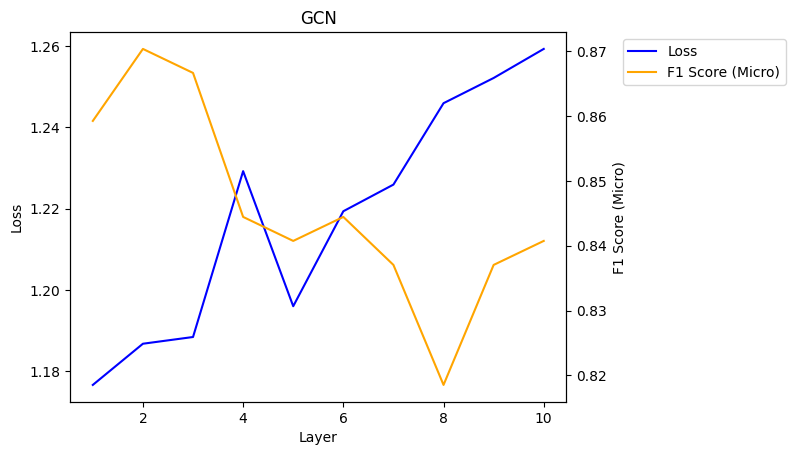

In [ ]:
# visualize
t = np.array(num_layers)
fig, ax1 = plt.subplots()

ax1.set_xlabel('Layer')
ax1.set_ylabel('Loss')
min_losses = [loss_history[-1] for loss_history in loss_gcn_by_layer.values()]
max_f1_scores = [valid_f1_history[-1] for valid_f1_history in valid_f1_gcn_by_layer.values()]
line1 = ax1.plot(t, min_losses, color='blue', label='Loss')

ax2 = ax1.twinx()
ax2.set_ylabel('F1 Score (Micro)')
line2 = ax2.plot(t, max_f1_scores, color='orange', label='F1 Score (Micro)')

lines = line1 + line2
labels = [line.get_label() for line in lines]

ax1.legend(lines, labels, loc="upper left", bbox_to_anchor=(1.1, 1))

plt.title('GCN')
plt.show()

In [ ]:
num_layers = list(range(1, 11))
feature_matrix_dict = dict()

for num_layer in num_layers:
    model = torch.load(f"model-gcn-{num_layer}.pt")
    model.eval()

    feature_matrix = model._forward_node_feature(feat, edge, degree)
    feature_matrix_dict[num_layer] = feature_matrix.detach().cpu()

In [ ]:
feature_matrix_dict[10][10, :]

tensor([0.1085, 0.0000, 0.0000, 0.1343, 0.1048, 0.0000, 0.0000, 0.2338, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1690, 0.0000, 0.1797,
        0.0000, 0.1236, 0.0000, 0.2150, 0.1998, 0.0000, 0.0440, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1556,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1407, 0.1149, 0.0000,
        0.0011, 0.0000, 0.1562, 0.2074, 0.1157, 0.1561, 0.0000, 0.1422, 0.1620,
        0.0000, 0.0000, 0.0000, 0.1222, 0.1885, 0.0000, 0.0654, 0.1552, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1880, 0.1556, 0.1674, 0.0000, 0.0000, 0.1284, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1037, 0.1286, 0.0000, 0.0000, 0.2103, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.1719, 0.0000, 0.0000, 0.0000, 0.1516,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1661, 0.0000, 0.0000,
        0.0000, 0.1969, 0.2088, 0.0000, 

In [ ]:
def visualize_node_feature(agg_type: str, num_layers: list[int], feat: torch.Tensor, edge: torch.Tensor,
                           degree: torch.Tensor, label: torch.Tensor, title: str) -> None:

    fig, axes = plt.subplots(2, 5, figsize=(15, 5))
    palette = sns.color_palette("bright", 7)

    for num_layer in num_layers:
        model = torch.load(f"model-{agg_type}-{num_layer}.pt")
        model.eval()

        feature_matrix = model._forward_node_feature(feat, edge, degree)
        feature_matrix = feature_matrix.detach().cpu()

        # T-SNE fitting for visualization
        tsne = PCA(n_components=2)
        X_embedded = tsne.fit_transform(feature_matrix)

        # Draw subplot
        i, j = divmod(num_layers.index(num_layer), 5)
        ax = axes[i, j]
        ax.set_xlim(-0.5, 0.5)
        ax.set_ylim(-0.75, 0.75)
        ax.set_title(f"Layer {num_layer}")
        sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=label, legend=False, palette=palette, ax=ax)

    plt.title(title)
    plt.show()


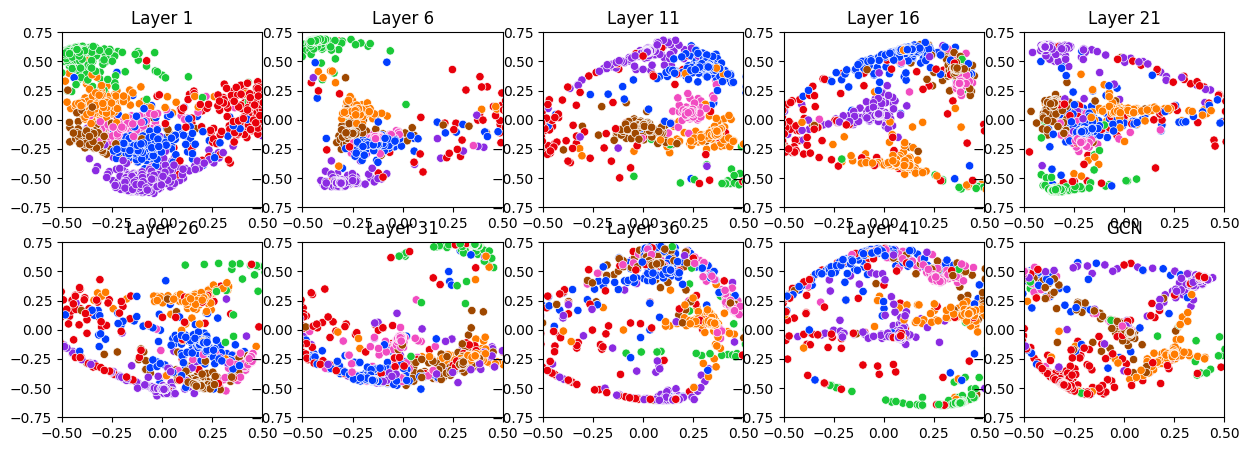

In [ ]:
visualize_node_feature("gcn", list(range(1, 51, 5)), feat, edge, degree, label, "GCN")

In [ ]:
mean_distances_by_k = dict()
for k in tqdm(range(1, 51, 5)):
    node_combination = combinations(range(num_node), 2)

    def calculate_distance(i, j):
        return torch.norm(feature_matrix_dict[k][i, :] - feature_matrix_dict[k][j, :])

    calculate_distance_vec = np.vectorize(calculate_distance)

    i, j = np.array(list(node_combination)).T
    distances = calculate_distance_vec(i, j)
    print(distances.shape)
    mean_distances_by_k[k] = np.mean(distances)
    print(mean_distances_by_k[k])

print(mean_distances_by_k)

 10%|█         | 1/10 [01:46<16:02, 106.93s/it]

(3665278,)
1.1151444790488823


 20%|██        | 2/10 [03:31<14:02, 105.36s/it]

(3665278,)
1.0626948331254864


 30%|███       | 3/10 [05:15<12:13, 104.80s/it]

(3665278,)
1.052278908064974


 40%|████      | 4/10 [06:56<10:20, 103.40s/it]

(3665278,)
1.0382656643516717


 50%|█████     | 5/10 [08:38<08:34, 102.87s/it]

(3665278,)
1.0424938925124176


 60%|██████    | 6/10 [10:21<06:51, 102.75s/it]

(3665278,)
1.04259550750575


 70%|███████   | 7/10 [12:02<05:06, 102.24s/it]

(3665278,)
1.0510356469360154


 80%|████████  | 8/10 [13:45<03:25, 102.54s/it]

(3665278,)
1.0474050205081415


 90%|█████████ | 9/10 [15:26<01:42, 102.16s/it]

(3665278,)
1.0501977159428644


100%|██████████| 10/10 [17:10<00:00, 103.06s/it]

(3665278,)
1.0516911998471015
{1: 1.1151444790488823, 2: 1.0626948331254864, 3: 1.052278908064974, 4: 1.0382656643516717, 5: 1.0424938925124176, 6: 1.04259550750575, 7: 1.0510356469360154, 8: 1.0474050205081415, 9: 1.0501977159428644, 10: 1.0516911998471015}


In [ ]:
# visualize loss-epoch
t = np.arange(200)
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
line1 = ax1.plot(t, loss_gcn_by_layer[1], color='red', label='k=1')

ax2 = ax1.twinx()
line2 = ax2.plot(t, loss_gcn_by_layer[2], color='orange', label='k=2')

ax3 = ax1.twinx()
line3 = ax3.plot(t, loss_gcn_by_layer[3], color='yellow', label='k=3')

ax4 = ax1.twinx()
line4 = ax4.plot(t, loss_gcn_by_layer[4], color='green', label='k=4')

ax5 = ax1.twinx()
line5 = ax5.plot(t, loss_gcn_by_layer[5], color='blue', label='k=5')

lines = line1 + line2 + line3 + line4 + line5
labels = [line.get_label() for line in lines]

ax1.legend(lines, labels, loc="upper left", bbox_to_anchor=(1.1, 1))

plt.title('GCN')
plt.show()